In [17]:
usingGoogleColab = False

### Imports

In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import imgaug as aug
import imgaug.augmenters as iaa
import glob
import cv2
import numpy as np
import pandas as pd
import os
import random
from statistics import mean
from IPython.display import clear_output

### Adjustable Parameters

In [19]:
RandomSeed = 42
random.seed(RandomSeed)
np.random.seed(RandomSeed)
tf.random.set_seed(RandomSeed)
aug.seed(RandomSeed)

img_width = 32
img_height = 32

numFold = 10
fold = StratifiedKFold(n_splits=numFold, shuffle=True, random_state=RandomSeed)
batchSize = 128
numEpochs = 20

### Helper Functions

In [20]:
def ShuffleData(xData, yData):
  indices = np.arange(xData.shape[0])
  np.random.shuffle(indices)

  return xData[indices], yData[indices]

def BuildModel():
  # Convolute Layers
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))

  # Neural Network Layers
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  return model

def CompileModel(model):
  model.compile(optimizer='sgd',
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'
                , tf.keras.metrics.Precision(name='precision')
                , tf.keras.metrics.Recall(name='recall')
                ])
def TrainModel(model, xTrain, yTrain, xTest, yTest):
  return model.fit(xTrain, yTrain
                   , epochs = numEpochs
                   , batch_size= batchSize
                   , verbose = 0
                   , validation_data=(xTest, yTest))

def TrainModel_ClassWeights(model, xTrain, yTrain, xTest, yTest, classWeights):
  return model.fit(xTrain, yTrain
                   , epochs = numEpochs
                   , batch_size = batchSize
                   , verbose = 0
                   , class_weight = classWeights
                   , validation_data=(xTest, yTest))
  
def GetHistoryAverage(histories):
  lastEpochHistory = []

  # Take metrics only from last epoch
  for foldHist in histories:
    myDict = {}
    for key in foldHist.history:
      myDict[key] = foldHist.history[key][-1]
    lastEpochHistory.append(myDict)


  print(histories[0].history.keys())

  avrgHistory = {}
  for key in histories[0].history.keys():
    avrgHistory[key] = mean([h[key] for h in lastEpochHistory])
    
  return avrgHistory

def EvaluateModel(model, xData, yData):
  metricsResults = model.evaluate(xData, yData
                        , verbose = 0
                        )
  return dict(zip(model.metrics_names, metricsResults))
  
def GetClassWeights(yData):
  uniqueLabels  = np.unique(yData)
  classWeightValues = class_weight.compute_class_weight(
    'balanced'
    , classes = uniqueLabels
    , y = yData
    )

  classWeights = {}
  idx = 0
  for label in uniqueLabels:
    classWeights[label] = classWeightValues[idx]
    idx = idx + 1

  return classWeights

def GenerateAugmentedData(dataset, amountToGen, AugData):
  dataLen = len(dataset)
  randomIndexList = random.shuffle([*range(dataLen)])
  # Augmentation sequence

  newData = []
  for i in range(amountToGen):
    idx = i % dataLen
    augmentedImg = AugData.augment(images=dataset[idx])
    newData.append(augmentedImg)

  return newData

### Loading of Default Data

In [21]:
imgs_N_Path = "Images/Default/NORMAL"
imgs_P_Path = "Images/Default/PNEUMONIA"

if usingGoogleColab:
  from google.colab import drive
  drive.mount('/content/drive')
  imgs_N_Path = "drive/MyDrive/CZ4042_Lab02/" + imgs_N_Path
  imgs_P_Path = "drive/MyDrive/CZ4042_Lab02/" + imgs_P_Path

img_N_List = os.listdir(imgs_N_Path)
img_P_List = os.listdir(imgs_P_Path)

xN = []
xP = []

for imgName in img_N_List:
  img = load_img(imgs_N_Path + "/" + imgName, target_size=(img_width, img_height))
  img = img_to_array(img)
  grayImg = np.array([[pixel[0] for pixel in row] for row in img]) #Since img is grayscaled, r, g, and b are same values, we only need one of it
  xN.append(grayImg)
for imgName in img_P_List:
  img = load_img(imgs_P_Path + "/" + imgName, target_size=(img_width, img_height))
  img = img_to_array(img)
  grayImg = np.array([[pixel[0] for pixel in row] for row in img])
  xP.append(grayImg)

### Dataset Analysis

1583  Normal Images
4273  Pneumonia Images
5856  Total Images


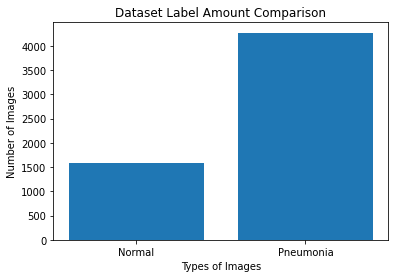

In [22]:
numNormals = len(xN)
numPneumonias = len(xP)

print(numNormals, " Normal Images")
print(numPneumonias, " Pneumonia Images")
print(numNormals + numPneumonias, " Total Images")

data = {
    'Normal': numNormals
    , 'Pneumonia': numPneumonias
    }

labels = data.keys()
values = data.values()
plt.bar(labels, values)
 
plt.xlabel("Types of Images")
plt.ylabel("Number of Images")
plt.title("Dataset Label Amount Comparison")
plt.show()

In [23]:
#Reserve 100 images of each category for testing
x = xN + xP
y = ([0] * len(xN)) + ([1] * len(xP))
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1, random_state=RandomSeed)

# Normalize pixel values to be between 0 and 1
xTest = np.array(xTest, dtype=np.float32)
xTrain = np.array(xTrain, dtype=np.float32)
yTest = np.array(yTest, dtype=np.float32)
yTrain = np.array(yTrain, dtype=np.float32)
xTest = xTest / 255.0
xTrain = xTrain / 255.0

# Shuffle data
xTrain, yTrain = ShuffleData(xTrain, yTrain)

In [24]:
model = BuildModel()
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_22 (Flatten)        (None, 1024)            

### Default Scenario

In [25]:
xData = xTrain
yData = yTrain

histories_df = []
foldIter = 1
for trainIndexes, testIndexes in fold.split(xData, yData):
    print(f'\tTraining {foldIter}/{numFold}: ')
    
    model = BuildModel()
    
    CompileModel(model)
    
    history = TrainModel(model, xData[trainIndexes], yData[trainIndexes], xData[testIndexes], yData[testIndexes])
    
    histories_df.append(history)
    
    foldIter += 1

clear_output(wait=True)
print("Training Done")

Training Done


In [26]:
avrgHistory_df = GetHistoryAverage(histories_df)

for key, value in avrgHistory_df.items():
  print("{:<15} {:<10}".format(key, value))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
loss            0.4945905417203903
accuracy        0.7507484674453735
precision       0.748711347579956
recall          0.9955434143543244
val_loss        0.5340226411819458
val_accuracy    0.7366223990917206
val_precision   0.7759564876556396
val_recall      0.9411917060613633


In [27]:
xDataTrain, xDataTest, yDataTrain, yDataTest = train_test_split(xTrain, yTrain, test_size=0.2, random_state=RandomSeed)

model = BuildModel()
    
CompileModel(model)

TrainModel(model, xDataTrain, yDataTrain, xDataTest, yDataTest)

metrics_df = EvaluateModel(model, xTest, yTest)

print(metrics_df)

{'loss': 0.5619741082191467, 'accuracy': 0.6979522109031677, 'precision': 0.6979522109031677, 'recall': 1.0}


### Adjusting Class Weights Scenario

In [28]:
lw = GetClassWeights(yTrain)

print(lw)

{0.0: 1.8741109530583215, 1.0: 0.681935817805383}


In [29]:
xData = xTrain
yData = yTrain

histories_cw = []
foldIter = 1
for trainIndexes, testIndexes in fold.split(xData, yData):
    print(f'\tTraining {foldIter}/{numFold}: ')
    
    model = BuildModel()
    
    CompileModel(model)

    classWeights = GetClassWeights(yData[trainIndexes])
    history = TrainModel_ClassWeights(model, xData[trainIndexes], yData[trainIndexes], xData[testIndexes], yData[testIndexes], classWeights)
    
    histories_cw.append(history)
    
    foldIter += 1

clear_output(wait=True)
print("Training Done")

Training Done


In [30]:
avrgHistory_cw = GetHistoryAverage(histories_cw)

for key, value in avrgHistory_cw.items():
  print("{:<15} {:<10}".format(key, value))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
loss            0.5280583202838898
accuracy        0.7913345992565155
precision       0.9243667244911193
recall          0.7792435884475708
val_loss        0.539438220858574
val_accuracy    0.740607213973999
val_precision   0.8928616583347321
val_recall      0.7778654754161834


In [31]:
xDataTrain, xDataTest, yDataTrain, yDataTest = train_test_split(xTrain, yTrain, test_size=0.2, random_state=RandomSeed)

model = BuildModel()
    
CompileModel(model)

labelWeights = GetClassWeights(yDataTrain)
TrainModel_ClassWeights(model, xDataTrain, yDataTrain, xDataTest, yDataTest, labelWeights)

metrics_cw = EvaluateModel(model, xTest, yTest)

print(metrics_cw)

{'loss': 0.6554113626480103, 'accuracy': 0.8447098731994629, 'precision': 0.9789156913757324, 'recall': 0.7946210503578186}


### Data Augmentation Scenario

In [32]:
# augData = iaa.OneOf([
#       iaa.Fliplr(), # horizontal flips
#       iaa.Affine(rotate=5), # roatation
#       iaa.Multiply((0.5, 1.5)) # random brightness
#       ])

# newData = GenerateAugmentedData(x[0:2], 15, augData)

# plt.figure(figsize=(50, 20))
# for i in range(len(newData)):
#   ax = plt.subplot(2, 15, i + 1)
#   plt.imshow(newData[i])
#   plt.axis("off")

In [33]:
augSequence = iaa.Sequential([
      iaa.Affine(rotate=5), # roatation
      iaa.Multiply((0.5, 1.5)), # random brightness
      iaa.Crop(percent=(0.02, 0.05)) # random crops
      ])
numNorm = np.count_nonzero(yTrain == 0)
numPneum = np.count_nonzero(yTrain == 1)
amountToGenerate = numPneum - numNorm
newData = GenerateAugmentedData(xTrain, amountToGenerate, augSequence)
newData = np.array(newData, dtype="float32")
newDataScaled = newData / 255.0

In [34]:
xData = np.append(xTrain, newDataScaled, axis=0)
yData = np.append(yTrain, [0] * len(newDataScaled), axis=0)

histories_da = []
foldIter = 1
for trainIndexes, testIndexes in fold.split(xData, yData):
    print(f'\tTraining {foldIter}/{numFold}: ')
    
    model = BuildModel()
    
    CompileModel(model)

    history = TrainModel(model, xData[trainIndexes], yData[trainIndexes], xData[testIndexes], yData[testIndexes])
    
    histories_da.append(history)
    
    foldIter += 1

clear_output(wait=True)
print("Training Done")

Training Done


In [35]:
avrgHistory_da = GetHistoryAverage(histories_da)

for key, value in avrgHistory_da.items():
  print("{:<15} {:<10}".format(key, value))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
loss            0.2889170378446579
accuracy        0.8711323261260986
precision       0.8271640241146088
recall          0.938750970363617
val_loss        0.30968937277793884
val_accuracy    0.8496480941772461
val_precision   0.8506993234157563
val_recall      0.8826572120189666


In [36]:
xDataTrain, xDataTest, yDataTrain, yDataTest = train_test_split(xTrain, yTrain, test_size=0.2, random_state=RandomSeed)

newData = GenerateAugmentedData(xDataTrain, amountToGenerate, augSequence)
newData = np.array(newData, dtype="float32")
newDataScaled = newData / 255.0

xDataTrain = np.append(xDataTrain, newDataScaled, axis=0)
yDataTrain = np.append(yDataTrain, [False] * len(newDataScaled), axis=0)
xDataTrain, yDataTrain = ShuffleData(xDataTrain, yDataTrain)
    
CompileModel(model)

TrainModel(model, xDataTrain, yDataTrain, xDataTest, yDataTest)

metrics_da = EvaluateModel(model, xTest, yTest)

print(metrics_da)

{'loss': 0.4538244605064392, 'accuracy': 0.7901023626327515, 'precision': 0.7698113322257996, 'recall': 0.9975550174713135}


### Data Augmentation Scenario 2

In [37]:
numNorm = np.count_nonzero(yTrain == 0)
amountToGenerate = numNorm // 2
newData = GenerateAugmentedData(xTrain, amountToGenerate, augSequence)
newData = np.array(newData, dtype="float32")
newDataScaled = newData / 255.0

In [38]:
xData = np.append(xTrain, newDataScaled, axis=0)
yData = np.append(yTrain, [0] * len(newDataScaled), axis=0)

histories_da2 = []
foldIter = 1
for trainIndexes, testIndexes in fold.split(xData, yData):
    print(f'\tTraining {foldIter}/{numFold}: ')
    
    model = BuildModel()
    
    CompileModel(model)

    history = TrainModel(model, xData[trainIndexes], yData[trainIndexes], xData[testIndexes], yData[testIndexes])
    
    histories_da2.append(history)
    
    foldIter += 1

clear_output(wait=True)
print("Training Done")

Training Done


In [39]:
avrgHistory_da2 = GetHistoryAverage(histories_da2)

for key, value in avrgHistory_da2.items():
  print("{:<15} {:<10}".format(key, value))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
loss            0.4392691791057587
accuracy        0.7927518725395203
precision       0.7642959773540496
recall          0.9852205991744996
val_loss        0.4345978796482086
val_accuracy    0.7915494382381439
val_precision   0.7688211858272552
val_recall      0.9813799440860749


In [40]:
xDataTrain, xDataTest, yDataTrain, yDataTest = train_test_split(xTrain, yTrain, test_size=0.2, random_state=RandomSeed)

newData = GenerateAugmentedData(xDataTrain, amountToGenerate, augSequence)
newData = np.array(newData, dtype="float32")
newDataScaled = newData / 255.0

xDataTrain = np.append(xDataTrain, newDataScaled, axis=0)
yDataTrain = np.append(yDataTrain, [False] * len(newDataScaled), axis=0)
xDataTrain, yDataTrain = ShuffleData(xDataTrain, yDataTrain)
    
CompileModel(model)

TrainModel(model, xDataTrain, yDataTrain, xDataTest, yDataTest)

metrics_da2 = EvaluateModel(model, xTest, yTest)

print(metrics_da2)

{'loss': 0.23121783137321472, 'accuracy': 0.9095563292503357, 'precision': 0.9299516677856445, 'recall': 0.9413203001022339}


### Loading of Equalized Data

In [41]:
imgs_N_Path = "Images/GrayscaleEqualized/NORMAL"
imgs_P_Path = "Images/GrayscaleEqualized/PNEUMONIA"

if usingGoogleColab:
  from google.colab import drive
  drive.mount('/content/drive')
  imgs_N_Path = "drive/MyDrive/CZ4042_Lab02/" + imgs_N_Path
  imgs_P_Path = "drive/MyDrive/CZ4042_Lab02/" + imgs_P_Path

img_N_List = os.listdir(imgs_N_Path)
img_P_List = os.listdir(imgs_P_Path)

xN = []
xP = []

for imgName in img_N_List:
  img = load_img(imgs_N_Path + "/" + imgName, target_size=(img_width, img_height))
  img = img_to_array(img)
  grayImg = np.array([[pixel[0] for pixel in row] for row in img]) #Since img is grayscaled, r, g, and b are same values, we only need one of it
  xN.append(grayImg)
for imgName in img_P_List:
  img = load_img(imgs_P_Path + "/" + imgName, target_size=(img_width, img_height))
  img = img_to_array(img)
  grayImg = np.array([[pixel[0] for pixel in row] for row in img])
  xP.append(grayImg)
  
#Reserve 100 images of each category for testing
x = xN + xP
y = ([0] * len(xN)) + ([1] * len(xP))
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1, random_state=RandomSeed)

# Normalize pixel values to be between 0 and 1
xTest = np.array(xTest, dtype=np.float32)
xTrain = np.array(xTrain, dtype=np.float32)
yTest = np.array(yTest, dtype=np.float32)
yTrain = np.array(yTrain, dtype=np.float32)
xTest = xTest / 255.0
xTrain = xTrain / 255.0

# Shuffle data
xTrain, yTrain = ShuffleData(xTrain, yTrain)

### Default Scenario (Equalized Dataset)

In [42]:
xData = xTrain
yData = yTrain

histories_df2 = []
foldIter = 1
for trainIndexes, testIndexes in fold.split(xData, yData):
    print(f'\tTraining {foldIter}/{numFold}: ')
    
    model = BuildModel()
    
    CompileModel(model)
    
    history = TrainModel(model, xData[trainIndexes], yData[trainIndexes], xData[testIndexes], yData[testIndexes])
    
    histories_df2.append(history)
    
    foldIter += 1

clear_output(wait=True)
print("Training Done")

Training Done


In [43]:
avrgHistory_df2 = GetHistoryAverage(histories_df2)

for key, value in avrgHistory_df2.items():
  print("{:<15} {:<10}".format(key, value))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
loss            0.3589298754930496
accuracy        0.8348091959953308
precision       0.854909110069275
recall          0.9340350508689881
val_loss        0.4284984678030014
val_accuracy    0.800379502773285
val_precision   0.8403157353401184
val_recall      0.9296294093132019


In [44]:
xDataTrain, xDataTest, yDataTrain, yDataTest = train_test_split(xTrain, yTrain, test_size=0.2, random_state=RandomSeed)

model = BuildModel()
    
CompileModel(model)

TrainModel(model, xDataTrain, yDataTrain, xDataTest, yDataTest)

metrics_df2 = EvaluateModel(model, xTest, yTest)

print(metrics_df2)

{'loss': 0.3428569436073303, 'accuracy': 0.8873720169067383, 'precision': 0.9112709760665894, 'recall': 0.9290953278541565}


### Loading of Customized Data

In [45]:
imgs_N_Path = "Images/MyTransform/NORMAL"
imgs_P_Path = "Images/MyTransform/PNEUMONIA"

if usingGoogleColab:
  from google.colab import drive
  drive.mount('/content/drive')
  imgs_N_Path = "drive/MyDrive/CZ4042_Lab02/" + imgs_N_Path
  imgs_P_Path = "drive/MyDrive/CZ4042_Lab02/" + imgs_P_Path

img_N_List = os.listdir(imgs_N_Path)
img_P_List = os.listdir(imgs_P_Path)

xN = []
xP = []

for imgName in img_N_List:
  img = load_img(imgs_N_Path + "/" + imgName, target_size=(img_width, img_height))
  img = img_to_array(img)
  grayImg = np.array([[pixel[0] for pixel in row] for row in img]) #Since img is grayscaled, r, g, and b are same values, we only need one of it
  xN.append(grayImg)
for imgName in img_P_List:
  img = load_img(imgs_P_Path + "/" + imgName, target_size=(img_width, img_height))
  img = img_to_array(img)
  grayImg = np.array([[pixel[0] for pixel in row] for row in img])
  xP.append(grayImg)
  
#Reserve 100 images of each category for testing
x = xN + xP
y = ([0] * len(xN)) + ([1] * len(xP))
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1, random_state=RandomSeed)

# Normalize pixel values to be between 0 and 1
xTest = np.array(xTest, dtype=np.float32)
xTrain = np.array(xTrain, dtype=np.float32)
yTest = np.array(yTest, dtype=np.float32)
yTrain = np.array(yTrain, dtype=np.float32)
xTest = xTest / 255.0
xTrain = xTrain / 255.0

# Shuffle data
xTrain, yTrain = ShuffleData(xTrain, yTrain)

### Default Scenario (Custom)

In [46]:
xData = xTrain
yData = yTrain

histories_df3 = []
foldIter = 1
for trainIndexes, testIndexes in fold.split(xData, yData):
    print(f'\tTraining {foldIter}/{numFold}: ')
    
    model = BuildModel()
    
    CompileModel(model)
    
    history = TrainModel(model, xData[trainIndexes], yData[trainIndexes], xData[testIndexes], yData[testIndexes])
    
    histories_df3.append(history)
    
    foldIter += 1

clear_output(wait=True)
print("Training Done")

Training Done


In [47]:
avrgHistory_df3 = GetHistoryAverage(histories_df3)

for key, value in avrgHistory_df3.items():
  print("{:<15} {:<10}".format(key, value))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
loss            0.327982971072197
accuracy        0.8596879541873932
precision       0.881434565782547
recall          0.9344376385211944
val_loss        0.38834020793437957
val_accuracy    0.8278937339782715
val_precision   0.8672353565692902
val_recall      0.9223761856555939


In [48]:
xDataTrain, xDataTest, yDataTrain, yDataTest = train_test_split(xTrain, yTrain, test_size=0.2, random_state=RandomSeed)

model = BuildModel()
    
CompileModel(model)

TrainModel(model, xDataTrain, yDataTrain, xDataTest, yDataTest)

metrics_df3 = EvaluateModel(model, xTest, yTest)

print(metrics_df3)

{'loss': 0.30013179779052734, 'accuracy': 0.8754266500473022, 'precision': 0.9137930870056152, 'recall': 0.9070904850959778}


### Comparison Table

In [49]:
metricsNames = ['loss', 'accuracy', 'precision', 'recall']
valMetricsNames = ['val_loss', 'val_accuracy', 'val_precision', 'val_recall']

df = pd.DataFrame(columns=['scenario'] + metricsNames)

df.loc[len(df.index)] = ["Default Train"] + [avrgHistory_df[name] for name in metricsNames]
df.loc[len(df.index)] = ["Default2 Train"] + [avrgHistory_df2[name] for name in metricsNames]
df.loc[len(df.index)] = ["Default3 Train"] + [avrgHistory_df3[name] for name in metricsNames]
df.loc[len(df.index)] = ["ClassWeights Train"] + [avrgHistory_cw[name] for name in metricsNames]
df.loc[len(df.index)] = ["DataAug Train"] + [avrgHistory_da[name] for name in metricsNames]
df.loc[len(df.index)] = ["DataAug2 Train"] + [avrgHistory_da2[name] for name in metricsNames]

df.loc[len(df.index)] = ["Default Validate"] + [avrgHistory_df[name] for name in valMetricsNames]
df.loc[len(df.index)] = ["Default2 Validate"] + [avrgHistory_df2[name] for name in valMetricsNames]
df.loc[len(df.index)] = ["Default3 Validate"] + [avrgHistory_df3[name] for name in valMetricsNames]
df.loc[len(df.index)] = ["ClassWeights Validate"] + [avrgHistory_cw[name] for name in valMetricsNames]
df.loc[len(df.index)] = ["DataAug Validate"] + [avrgHistory_da[name] for name in valMetricsNames]
df.loc[len(df.index)] = ["DataAug2 Validate"] + [avrgHistory_da2[name] for name in valMetricsNames]

df.loc[len(df.index)] = ["Default Test"] + list(metrics_df.values())
df.loc[len(df.index)] = ["Default2 Test"] + list(metrics_df2.values())
df.loc[len(df.index)] = ["Default3 Test"] + list(metrics_df3.values())
df.loc[len(df.index)] = ["ClassWeights Test"] + list(metrics_cw.values())
df.loc[len(df.index)] = ["DataAug Test"] + list(metrics_da.values())
df.loc[len(df.index)] = ["DataAug2 Test"] + list(metrics_da2.values())


print(df.loc[:5])
print()
print(df.loc[6:11])
print()
print(df.loc[12:])

             scenario      loss  accuracy  precision    recall
0       Default Train  0.494591  0.750748   0.748711  0.995543
1      Default2 Train  0.358930  0.834809   0.854909  0.934035
2      Default3 Train  0.327983  0.859688   0.881435  0.934438
3  ClassWeights Train  0.528058  0.791335   0.924367  0.779244
4       DataAug Train  0.288917  0.871132   0.827164  0.938751
5      DataAug2 Train  0.439269  0.792752   0.764296  0.985221

                 scenario      loss  accuracy  precision    recall
6        Default Validate  0.534023  0.736622   0.775956  0.941192
7       Default2 Validate  0.428498  0.800380   0.840316  0.929629
8       Default3 Validate  0.388340  0.827894   0.867235  0.922376
9   ClassWeights Validate  0.539438  0.740607   0.892862  0.777865
10       DataAug Validate  0.309689  0.849648   0.850699  0.882657
11      DataAug2 Validate  0.434598  0.791549   0.768821  0.981380

             scenario      loss  accuracy  precision    recall
12       Default Test  0.